## 1. Settings and Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from sklearn.impute import SimpleImputer

In [2]:
# Define class for handling notebook and dataset imports and settings
class CF:

    def __init__(self):
        self.dataset = Path("ST001906_1.txt")

        if not self.dataset.exists():
            raise FileNotFoundError(f"Dataset {self.dataset} not found.")


## 2. Data Exploration

In [3]:
# load dataset skipping the first and last 3 rows
df = pd.read_csv(
    CF().dataset, 
    sep="\t", 
    header=0, 
    skiprows=1,
    skipfooter=3,
    engine="python"
)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Metabolite_name  79 non-null     object
 1   RefMet_name      79 non-null     object
 2   C01              79 non-null     object
 3   C02              79 non-null     object
 4   C03              79 non-null     object
 5   C04              77 non-null     object
 6   C05              79 non-null     object
 7   C06              79 non-null     object
 8   C07              79 non-null     object
 9   C08              79 non-null     object
 10  C09              79 non-null     object
 11  C10              79 non-null     object
 12  C11              78 non-null     object
 13  C12              79 non-null     object
 14  C13              78 non-null     object
 15  C14              79 non-null     object
 16  C15              78 non-null     object
 17  C16              78 non-null     obje

In [5]:
# test for duplicates 
df.duplicated().sum()

np.int64(0)

In [6]:
df.head()

,Metabolite_name,RefMet_name,C01,C02,C03,C04,C05,C06,C07,C08,...,P23B,P24B,P25B,P26B,P27B,P29B,P30B,P31B,P32B,P33B
0,Factors,-,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,...,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes
1,1_5-Anhydroglucitol,"1,5-Anhydrosorbitol",76134.0679,68229.8179,75060.0460,21889.5860,61684.2890,115496.8453,77569.5444,87619.4513,...,1366.5750,4011.0743,1485.9307,4361.8853,23685.9709,13167.1581,42091.9933,2360.8300,889.5784,5389.3421
2,2-Aminobutyrate,2-Aminobutyric acid,2483.6464,1171.0519,1812.2221,982.1933,1525.7878,1090.4060,1269.0313,1786.2425,...,2203.0673,3151.7086,2574.6249,3184.0889,2672.3013,2889.2573,2284.7122,3026.2174,3586.0458,3237.7158
3,2-Hydroxybutyrate,2-Hydroxybutyric acid,4785.6271,4043.5030,3822.1668,4140.3742,6823.5424,9683.3429,6729.0747,6613.6143,...,14332.5561,16349.3766,16522.0347,21152.4515,15942.5127,15007.9743,10137.0140,17545.8158,8798.9741,22780.4208
4,3-Aminoisobutyrate,3-Aminoisobutanoic acid,3170.5029,3031.3133,3015.3690,3579.3690,2776.2411,4072.6505,3019.2438,2940.5403,...,6140.5615,3852.9904,3404.6428,5132.2698,4150.2105,3362.3410,3887.4223,2959.2192,4809.2734,3006.8964


In [7]:
# Drop one of the columns with the metabolite names
df.drop(columns=["RefMet_name"], inplace=True)

In [8]:
# Transpose the dataframe to have metabolites as columns
# rename the approprite columns containung the class labels and sample IDs
df = df.T
df.columns = df.iloc[0] # use the first row as the column names
df = df.iloc[1:]        # drop the first row
df.reset_index(inplace=True)

df.rename(columns={
    "index": "ID",
    "Factors": "Class"
}, inplace=True)

df.columns.name = None  # remove the name of the index column


In [9]:
df.head()

,ID,Class,1_5-Anhydroglucitol,2-Aminobutyrate,2-Hydroxybutyrate,3-Aminoisobutyrate,3-Hydroxybutyrate,Alanine,Allose,alpha-Tocopherol,...,Succinate,Threonate,Threonine,Tryptophan,Tyrosine,Urate,Urea,Uridine,Valine,Xylulose
0,C01,Diagnosis:Control,76134.0679,2483.6464,4785.6271,3170.5029,78663.0271,325359.7759,13080.7146,17004.6243,...,2298.1521,5507.2429,53797.8621,196307.0489,132745.3571,227581.6297,2500712.2060,2388.3416,402362.8160,902.2380
1,C02,Diagnosis:Control,68229.8179,1171.0519,4043.5030,3031.3133,17390.0075,323430.1298,12230.4685,21773.9858,...,2287.1496,2123.0647,50510.9227,261875.3204,182488.5616,144834.5131,2728527.7610,2229.2537,463447.9622,492.9723
2,C03,Diagnosis:Control,75060.0460,1812.2221,3822.1668,3015.3690,17036.9851,257628.0056,9330.0788,14931.4521,...,2829.0987,3339.2427,41762.9209,226547.3473,118124.2550,231965.0438,2489866.2910,1478.4680,352389.1496,877.0040
3,C04,Diagnosis:Control,21889.5860,982.1933,4140.3742,3579.3690,14830.6049,480618.6042,9259.4009,13318.2075,...,2789.5426,2929.9679,43210.8286,166942.0816,123024.1937,102890.4736,1480693.2910,1379.7791,307739.7556,697.2607
4,C05,Diagnosis:Control,61684.2890,1525.7878,6823.5424,2776.2411,17699.7571,367881.7294,10301.2117,13517.0489,...,3720.4811,3280.4422,35082.3522,186303.5238,142509.9754,205703.5966,1839377.0810,1327.8250,365375.5512,861.3556


In [ ]:
# convert the class labels to 0 and 1
df["Class"] = df["Class"].map({
    "Diagnosis:Control": 0,
    "Diagnosis:Diabetes": 1})
# convert the data objects into numbers where possible
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        print(f"Column {col} could not be converted to numeric")
df.info()

Column ID could not be converted to numeric


In [ ]:
# Basic descriptive statistics
df.describe()

,Class,1_5-Anhydroglucitol,2-Aminobutyrate,2-Hydroxybutyrate,3-Aminoisobutyrate,3-Hydroxybutyrate,Alanine,Allose,alpha-Tocopherol,Arabinose,...,Succinate,Threonate,Threonine,Tryptophan,Tyrosine,Urate,Urea,Uridine,Valine,Xylulose
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,60.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000
mean,0.508197,40880.637982,2119.166090,10881.508900,3357.055641,76975.547415,392346.945926,14720.395377,15928.659567,508.818472,...,2377.259621,3503.297731,40091.115074,188024.001170,135009.009959,164419.081715,2.165805e+06,1881.689859,419079.895003,955.144870
std,0.504082,33364.642840,795.585692,5486.700165,902.750248,78855.677869,102175.734405,5641.395620,4887.833643,290.104188,...,704.051509,2201.009677,10284.258310,34345.773134,24279.559654,41871.321461,5.710768e+05,521.032839,95083.833836,374.471377
min,0.000000,889.578400,526.621200,3822.166800,1980.980500,14117.535900,95288.601200,8784.138400,8071.738200,83.183000,...,1253.817200,818.950600,13104.349100,102714.665700,91448.036800,91506.709100,1.297209e+06,989.242600,108689.961300,414.758700
25%,0.000000,10562.167700,1592.369900,6721.705200,2952.793500,23445.070300,323430.129800,10562.006275,12619.209000,322.551300,...,1765.012600,2144.429200,33234.266300,165262.439800,118124.255000,133447.493300,1.807020e+06,1458.638000,358871.780900,678.782000
50%,1.000000,36735.764800,2032.147700,9673.126600,3150.522300,44434.173100,383280.704600,13452.410150,14509.073700,446.973500,...,2287.149600,3062.948900,40655.670400,183653.266200,132308.510900,162234.268500,2.130706e+06,1844.558000,415549.084700,890.503900
75%,1.000000,71367.725400,2685.870900,15007.974300,3647.682800,97269.652300,465394.402200,16658.345375,17725.157600,667.233400,...,2867.828200,4177.609100,46969.390400,206524.091600,147490.242900,194961.070300,2.489866e+06,2239.132100,463447.962200,1133.647100
max,1.000000,115496.845300,4397.556300,28975.823000,7219.206200,372262.774000,675140.720000,33334.776700,36460.662000,1668.365100,...,3780.038800,14739.957400,70849.607000,276209.272000,187237.572200,246924.354900,3.866027e+06,3406.387700,660563.253800,2032.840200


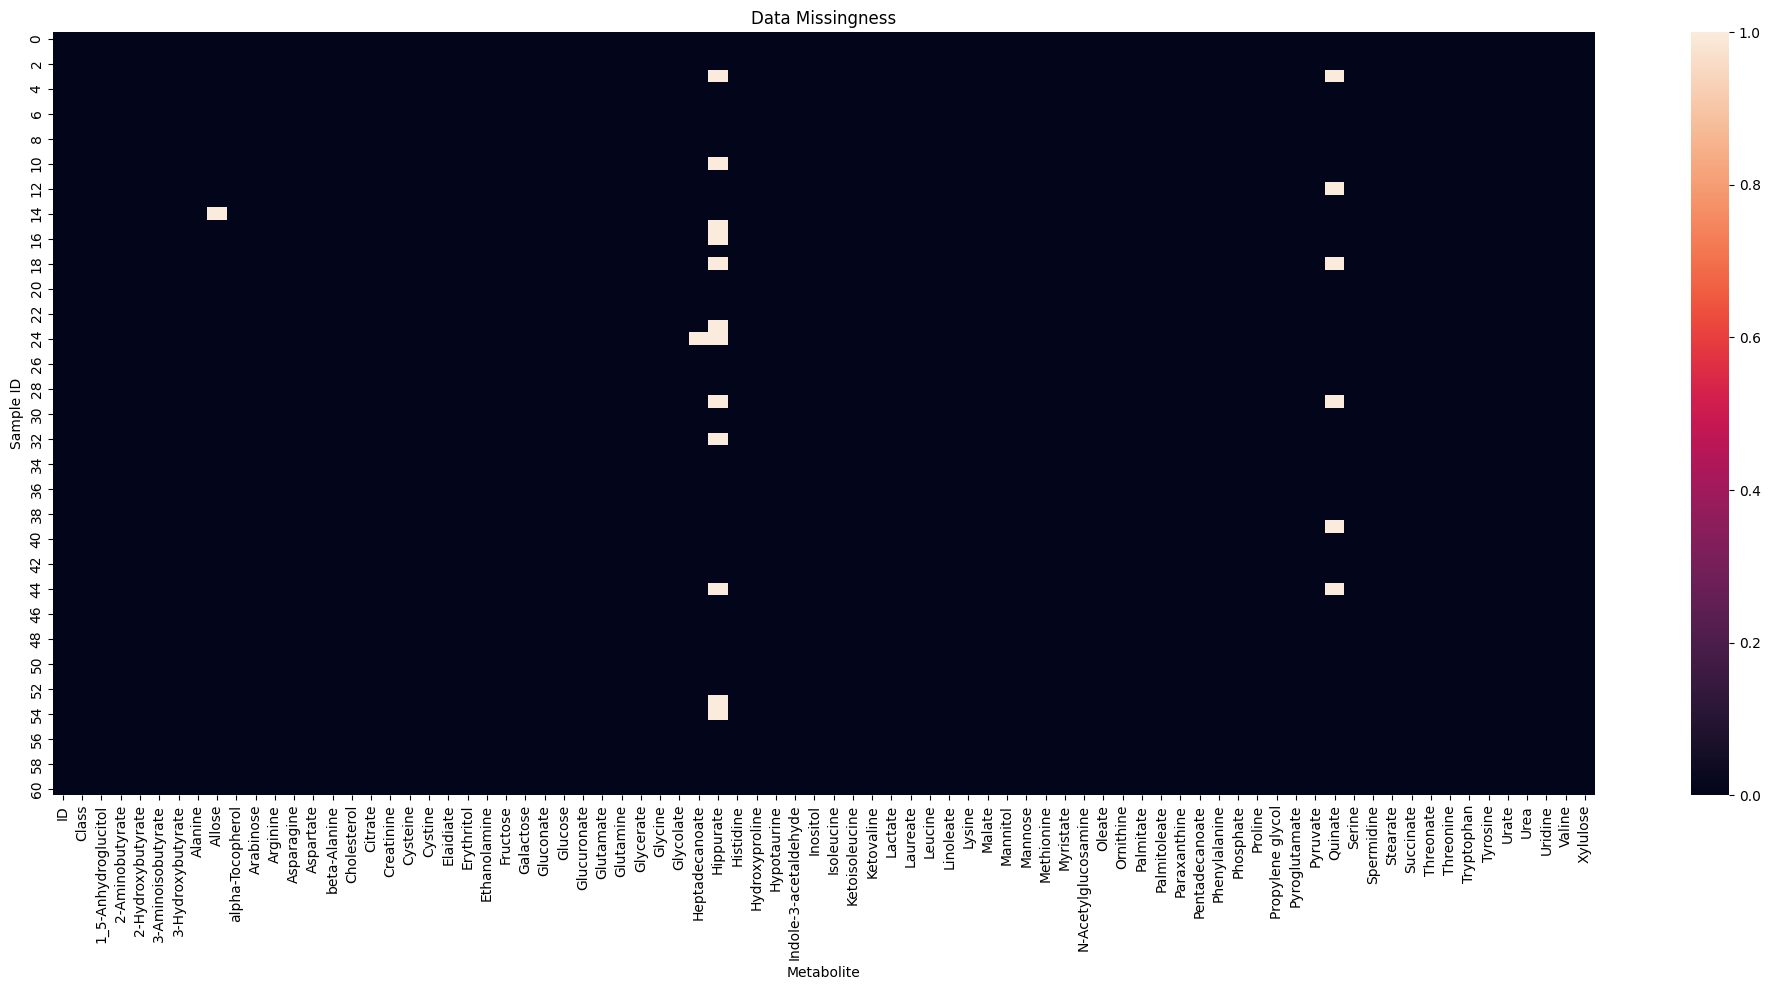

In [32]:
# Vizualise data missigness
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull())
plt.title("Data Missingness")
plt.ylabel("Sample ID")
plt.xlabel("Metabolite")
plt.tight_layout()

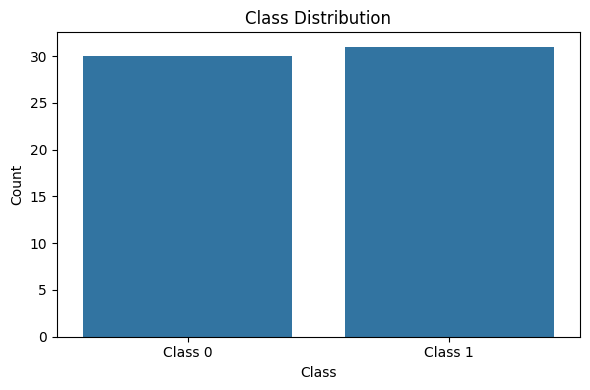

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["Class 0", "Class 1"])
plt.tight_layout()
plt.show()

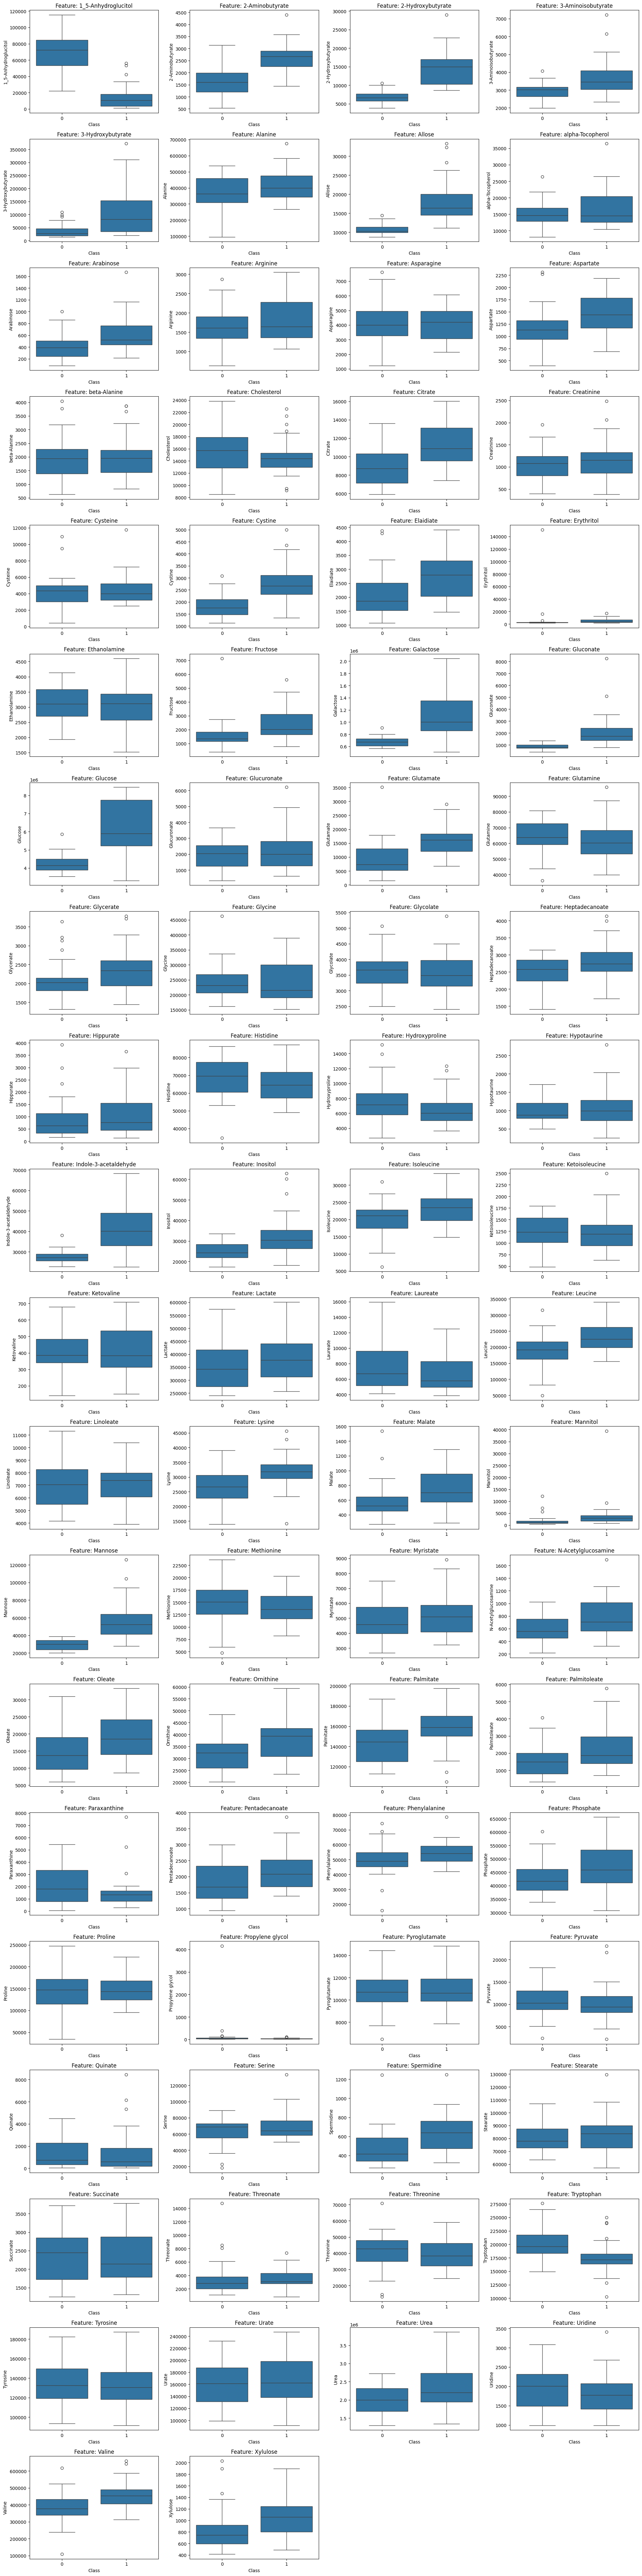

In [13]:
# plot box plots for each metabolite with the class labels
feature_cols = [col for col in df.columns if col != "ID" and col != "Class"]

# Grid set up
cols_per_row = 4
total_plots = len(feature_cols)
rows = math.ceil(total_plots / cols_per_row)

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(feature_cols):
    plt.subplot(rows, cols_per_row, i + 1)  # plt.subplots is 1-based not 0-based
    sns.boxplot(x="Class", y=col, data=df)
    plt.title(f"Feature: {col}")
    plt.tight_layout()

plt.show()


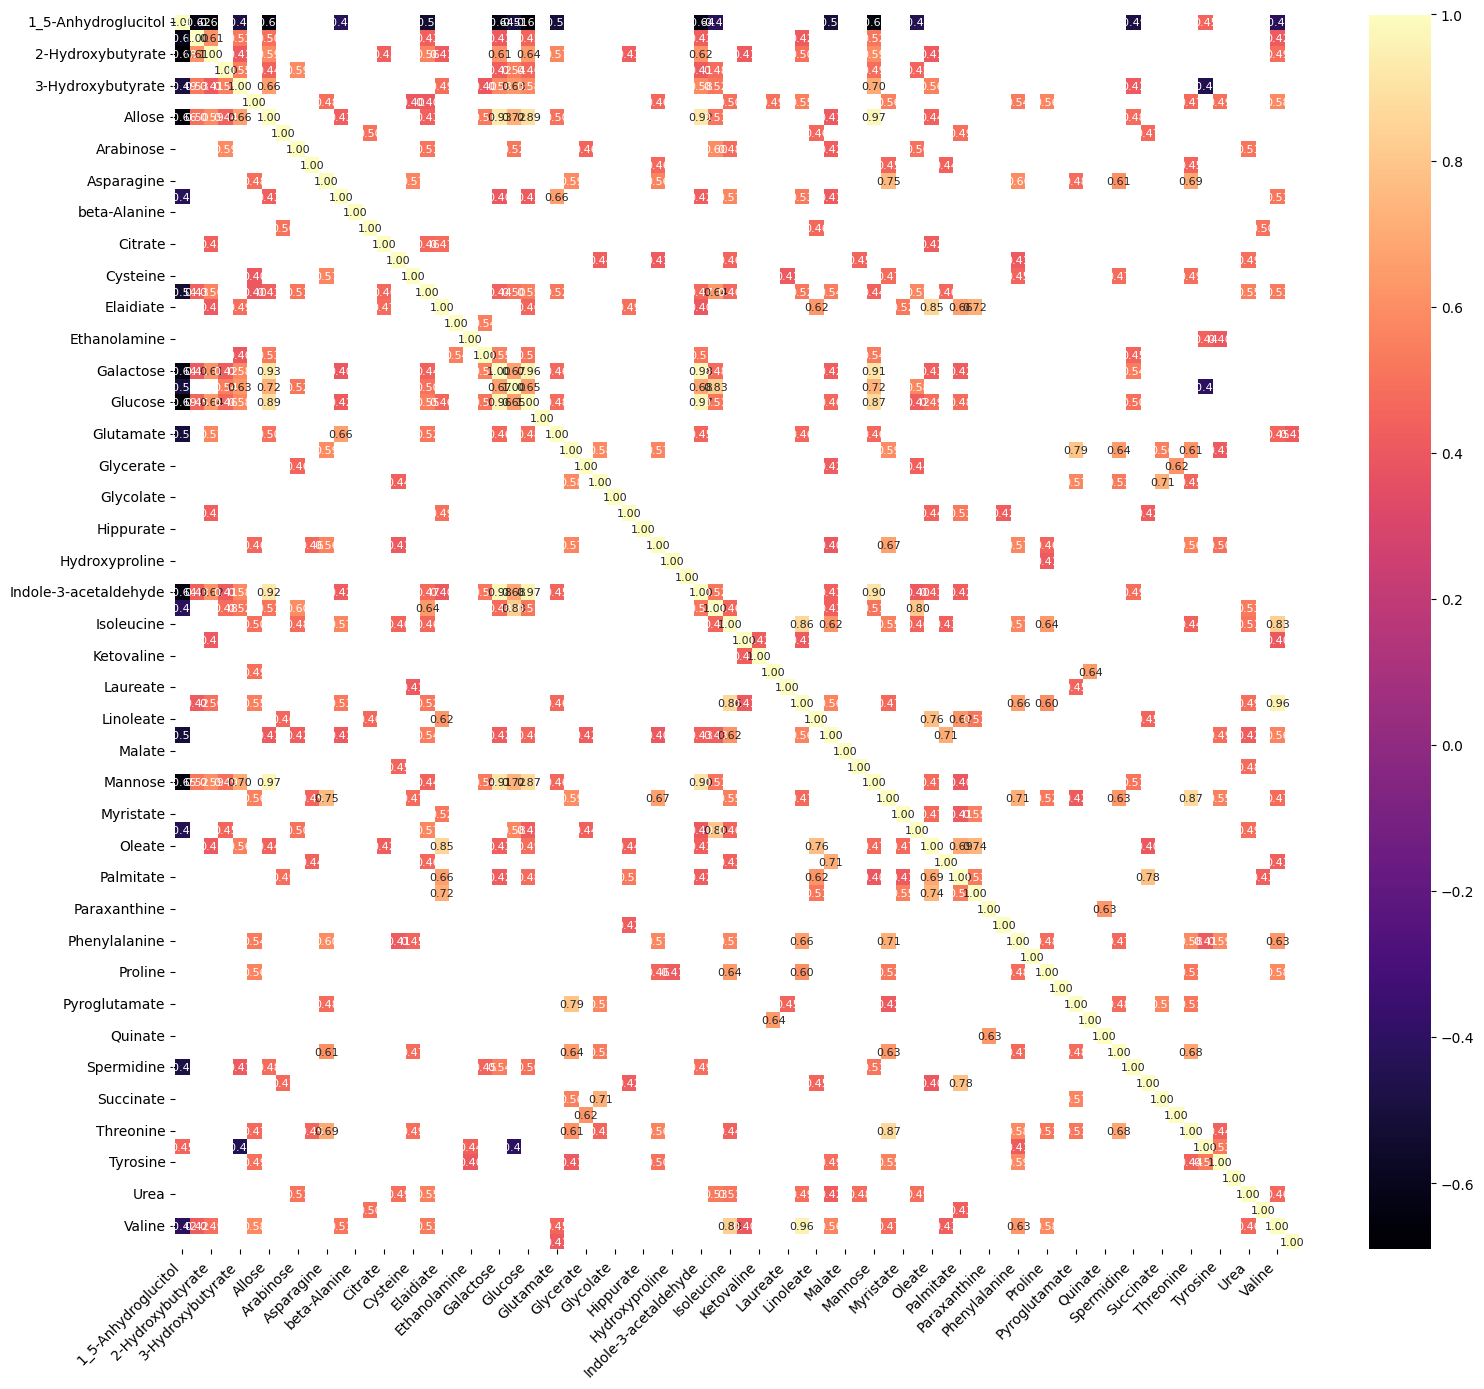

In [45]:
# correlation heatmap

# Compute correlation matrix and mask correlations with |r| < 0.4
corr = df[feature_cols].corr()
mask = np.abs(corr) < 0.4

# Generate the heatmap with correlation values
plt.figure(figsize=(16, 14))
sns.heatmap(corr,
            mask=mask, 
            annot=True, 
            fmt=".2f",         # Limit decimal places
            cmap='magma',      # Use a visually distinct color map
            annot_kws={"size": 8})  # Adjust annotation font size

# Improve tick label appearance
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Basic Statistics

In [14]:
# test for normal distribution 
results = []

for col in feature_cols:
    for cls in df["Class"].unique():
        data = df[df["Class"] == cls][col]
        stat, p = shapiro(data)
        results.append({
            "feature": col,
            "class": cls,
            "W-statistics": stat,
            "p-value": p,
            "Normal?": "Yes" if p > 0.05 else "No"
        })

normality_df = pd.DataFrame(results)
normality_df    


,feature,class,W-statistics,p-value,Normal?
0,1_5-Anhydroglucitol,0,0.984697,0.931921,Yes
1,1_5-Anhydroglucitol,1,0.798345,0.000048,No
2,2-Aminobutyrate,0,0.980627,0.841978,Yes
3,2-Aminobutyrate,1,0.964982,0.392560,Yes
4,2-Hydroxybutyrate,0,0.966748,0.454431,Yes
...,...,...,...,...,...
151,Uridine,1,0.937441,0.070124,Yes
152,Valine,0,0.948115,0.150471,Yes
153,Valine,1,0.961292,0.315534,Yes
154,Xylulose,0,0.837434,0.000342,No


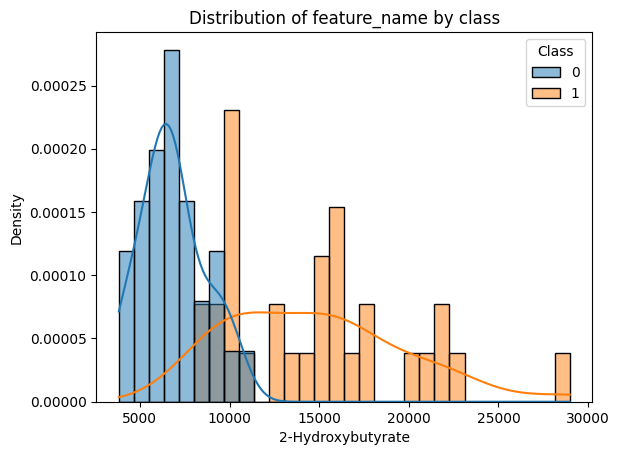

In [22]:
sns.histplot(data=df, x='2-Hydroxybutyrate', hue="Class", bins=30, kde=True, stat='density', common_norm=False)
plt.title("Distribution of feature_name by class")
plt.show()

C:\Users\tomla\AppData\Local\Temp\ipykernel_24916\1404539677.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_numeric = heatmap_data.replace({"Yes": 1, "No": 0, "Too few samples": None})


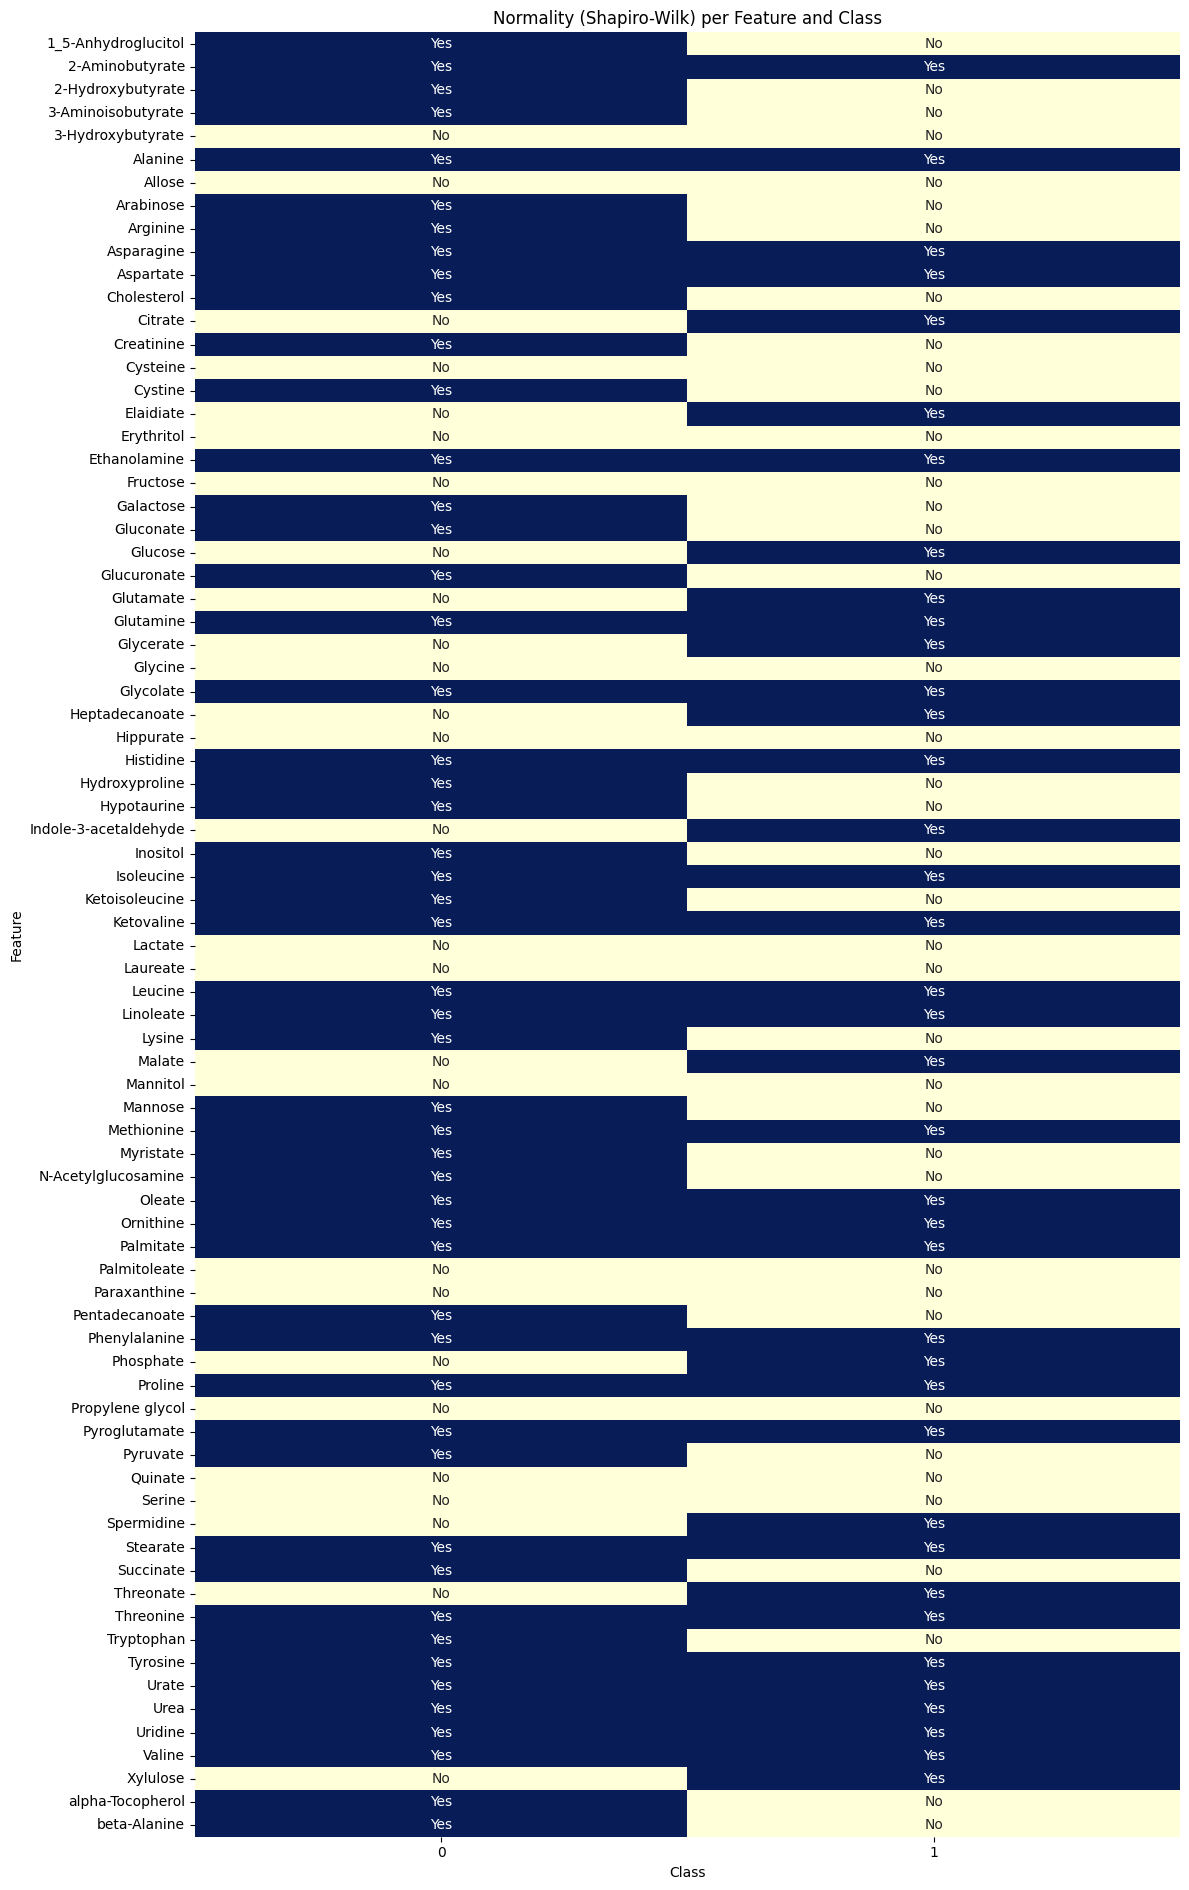

In [ ]:
# Vizualise the results as heatmap for all features
heatmap_data = normality_df.pivot(index="feature", columns="class", values="Normal?")
heatmap_numeric = heatmap_data.replace({"Yes": 1, "No": 0, "Too few samples": None})
plt.figure(figsize=(12, len(feature_cols) // 4))
sns.heatmap(heatmap_numeric, annot=heatmap_data, fmt='', cmap="YlGnBu", cbar=False)
plt.title("Normality (Shapiro-Wilk) per Feature and Class")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 4. Feature Selection

Since the data is not normally distributed, we will use the Mann–Whitney U test to compare the means between the two classes for each feature. This will become a starting point for future feature selection

In [ ]:
results = []

# Run Mann–Whitney U test for each feature
for feature in feature_cols:
    group_0 = df[df["Class"] == 0][feature]
    group_1 = df[df["Class"] == 1][feature]

    # impute missing values using median to prevent NaN p-values
    group_0 = SimpleImputer(strategy="median").fit_transform(group_0.values.reshape(-1, 1)).flatten()
    group_1 = SimpleImputer(strategy="median").fit_transform(group_1.values.reshape(-1, 1)).flatten()

    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')

    results.append({
        'Feature': feature,
        'U-statistic': stat,
        'p-value': p,
        "Significant?": "Yes" if p < 0.05 else "No"
    })

# Convert to DataFrame
mw_df = pd.DataFrame(results)

# Apply Benjamini–Hochberg correction (FDR-False Discovery Rate) (to reduce Type I error (false positive))
_, pvals_corrected, _, _ = multipletests(mw_df['p-value'], method='fdr_bh')
mw_df['Corrected p-value'] = pvals_corrected
mw_df['Significant (FDR < 0.05)'] = pvals_corrected < 0.05

# Sort by p-value
mw_df = mw_df.sort_values(by='Corrected p-value')

# Show or export results
mw_df.tail()

,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)
10,Asparagine,473.0,0.913840,No,0.950393,False
40,Ketovaline,456.0,0.902406,No,0.950393,False
25,Glucuronate,464.0,0.994245,No,1.000000,False
12,beta-Alanine,465.0,1.000000,No,1.000000,False
72,Tyrosine,467.0,0.982736,No,1.000000,False


In [ ]:
# Check for NaN p-values
mw_df.info()

nan_pvals = mw_df[mw_df['p-value'].isna()]
nan_pvals

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 72
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Feature                   78 non-null     object 
 1   U-statistic               78 non-null     float64
 2   p-value                   78 non-null     float64
 3   Significant?              78 non-null     object 
 4   Corrected p-value         78 non-null     float64
 5   Significant (FDR < 0.05)  78 non-null     bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 3.7+ KB


,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)


In [25]:
# Show features with significant p-values between classes
signinificant_features = mw_df[mw_df["Significant (FDR < 0.05)"] == True]

print(f"There are {len(signinificant_features)} significant features.")
signinificant_features

There are 34 significant features.


,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)
0,1_5-Anhydroglucitol,904.0,2.517471e-10,Yes,5.912185e-09,True
2,2-Hydroxybutyrate,24.0,2.087510e-10,Yes,5.912185e-09,True
6,Allose,28.0,3.031890e-10,Yes,5.912185e-09,True
23,Gluconate,27.0,2.763756e-10,Yes,5.912185e-09,True
48,Mannose,32.0,4.393901e-10,Yes,6.854486e-09,True
22,Galactose,62.0,6.376805e-09,Yes,8.289846e-08,True
24,Glucose,67.0,9.783944e-09,Yes,1.090211e-07,True
36,Indole-3-acetaldehyde,77.0,2.268475e-08,Yes,2.211763e-07,True
17,Cystine,124.0,9.008933e-07,Yes,7.807742e-06,True
1,2-Aminobutyrate,141.0,3.057925e-06,Yes,2.385182e-05,True


In [28]:
df.columns

Index(['ID', 'Class', '1_5-Anhydroglucitol', '2-Aminobutyrate',
       '2-Hydroxybutyrate', '3-Aminoisobutyrate', '3-Hydroxybutyrate',
       'Alanine', 'Allose', 'alpha-Tocopherol', 'Arabinose', 'Arginine',
       'Asparagine', 'Aspartate', 'beta-Alanine', 'Cholesterol', 'Citrate',
       'Creatinine', 'Cysteine', 'Cystine', 'Elaidiate', 'Erythritol',
       'Ethanolamine', 'Fructose', 'Galactose', 'Gluconate', 'Glucose',
       'Glucuronate', 'Glutamate', 'Glutamine', 'Glycerate', 'Glycine',
       'Glycolate', 'Heptadecanoate', 'Hippurate', 'Histidine',
       'Hydroxyproline', 'Hypotaurine', 'Indole-3-acetaldehyde', 'Inositol',
       'Isoleucine', 'Ketoisoleucine', 'Ketovaline', 'Lactate', 'Laureate',
       'Leucine', 'Linoleate', 'Lysine', 'Malate', 'Mannitol', 'Mannose',
       'Methionine', 'Myristate', 'N-Acetylglucosamine', 'Oleate', 'Ornithine',
       'Palmitate', 'Palmitoleate', 'Paraxanthine', 'Pentadecanoate',
       'Phenylalanine', 'Phosphate', 'Proline', 'Propylene g